# Proyecto 2 - Detección de pases en vídeos de jugadas de fútbol de la liga alemana

## Fútbol
El fútbol o balón pie es el deporte cuspide a nivel mundial, siendo incluso un fenómeno cultural. Los pases son esenciales para mantener la posición del balón, conducirse rápidamente por la cancha, generar oportunidades de gol y armar jugadas clave. La detección de los pases es clave pues nos hace posible poder detectar la efectividad de un equipo y su nivel de pases, haciendo así posible mejorar la calidad de cualquier equipo.

## Bundesliga
La liga alemana de fútbol tiene divisiones por categorías deportiva, siendo la máxima competición la bundesliga, siendo parte de la máxima categoría del fútbol. Esto añade ciertos beneficios al momento de hacer el análisis, pues al ser la máxima competición permite tener mejores métricas y mejor calidad de imagen en la base de datos, además de poder tener datos de comparación relativos para el estudio

In [1]:
#Librerías
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import numpy as np
import pylab
import sklearn.mixture as mixture
import random
from itertools import permutations
from seaborn import heatmap, countplot

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# Limpieza de datos

In [7]:
# Cargando el dataset
data = pd.read_csv('train.csv')

# Mostrando información básica del dataset
info = {
    "Número de filas": data.shape[0],
    "Número de columnas": data.shape[1],
    "Primeras filas": data.head(),
    "Información general": data.info()
}

info["Número de filas"], info["Número de columnas"], info["Primeras filas"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11218 entries, 0 to 11217
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   video_id          11218 non-null  object 
 1   time              11218 non-null  float64
 2   event             11218 non-null  object 
 3   event_attributes  4382 non-null   object 
dtypes: float64(1), object(3)
memory usage: 350.7+ KB


(11218,
 4,
      video_id        time      event           event_attributes
 0  1606b0e6_0  200.265822      start                        NaN
 1  1606b0e6_0  201.150000  challenge     ['ball_action_forced']
 2  1606b0e6_0  202.765822        end                        NaN
 3  1606b0e6_0  210.124111      start                        NaN
 4  1606b0e6_0  210.870000  challenge  ['opponent_dispossessed'])

In [9]:
data['event_attributes_clean'] = data['event_attributes'].fillna("No attribute")

# Definición de la función string_to_list
def string_to_list(s):
    if s != "No attribute":
        try:
            return ast.literal_eval(s)
        except:
            return [s]
    else:
        return []

# Aplicando la transformación a la columna
data['event_attributes_clean'] = data['event_attributes_clean'].apply(string_to_list)

# Verificando los cambios
data[['event_attributes', 'event_attributes_clean']].head()


,event_attributes,event_attributes_clean
0,NaN,[]
1,['ball_action_forced'],[['ball_action_forced']]
2,NaN,[]
3,NaN,[]
4,['opponent_dispossessed'],[['opponent_dispossessed']]


In [10]:
#  Convertir la columna `event` en categórica
data['event'] = data['event'].astype('category')

# Verificando el cambio
data['event'].dtype


CategoricalDtype(categories=['challenge', 'end', 'play', 'start', 'throwin'], ordered=False)

In [11]:
#  Verificar eventos duplicados
duplicated_events = data[data.duplicated(subset=['video_id', 'time'], keep=False)].sort_values(by=['video_id', 'time'])

duplicated_events_count = len(duplicated_events)
duplicated_events_count, duplicated_events.head(10)  # Mostrando los primeros 10 registros duplicados


(0,
 Empty DataFrame
 Columns: [video_id, time, event, event_attributes, event_attributes_clean]
 Index: [])

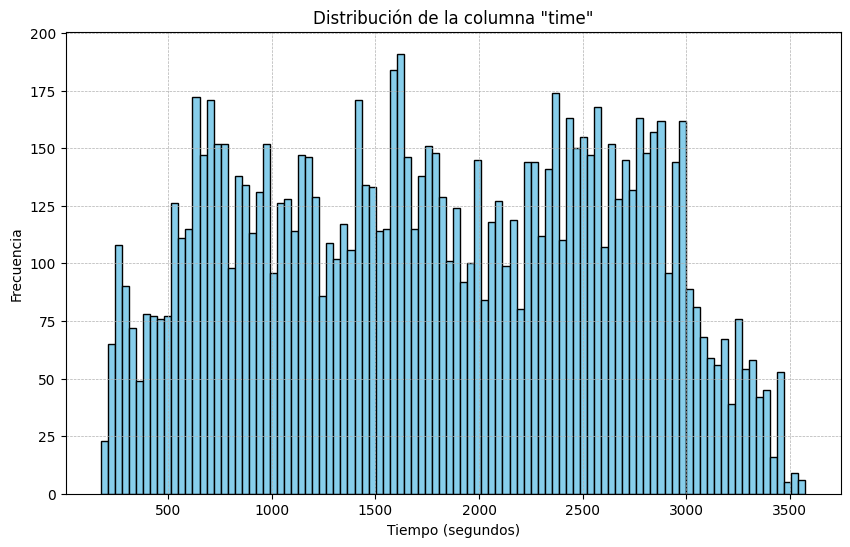

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(data['time'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribución de la columna "time"')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Frecuencia')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Análisis exploratorio